Fitting demo
--------------

This demonstrates the overall approach to data loading, model construction and fitting.

In [1]:
# Temporary hack to fix theano import issues
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

from functools import partial

from nems.recording import Recording
from nems.model import Model
from nems.modules.api import (WeightChannelsGaussian, FIR, DoubleExponential, Sum)

from nems.fitters import scipy
from nems.fitters import pymc3
from nems.metrics.api import mse

import numpy as np
import pylab as pl
import pymc3 as mc

%matplotlib inline

## Data loading

We have not fully integrated the Recording/Signal class into the `Model.evaluate` system. This requires a little bit of thought as to the best approach to use. For now, consider this a temporary hack (it shouldn't be hard to restructure down the road). I'd like to do some profiling so we have a baseline to tell us how expensive unpacking and packing data from/to a Recording will be.


In [2]:
# Load the data 
recording = Recording.load('../../signals/zee021e02_p_RDT/')

In [ ]:
class MyModule:
    
    input1 = 'stim1'
    input2 = 'pupil'
    
    def evaluate(self, data, phi):
        x = data[self.input1]
        y = data[self.input2]
        return {
            'my_output': x * y,
        }

In [11]:
FIR??

def fir_wrapper(data, input_name, output_name, coefficients)
    x = data[input_name]
    return {
        output_name: fir_filter(x, coefficients)
    }

{
    'name': ...
    'evaluate': fir_wrapper
}

In [3]:
# For now, I am using the raw arrays in the evaluate functions. 
# We'll explore better integration with recording later.
signals = {k: v.as_continuous() for k, v in recording.signals.items()}

## Model construction

At the most fundamental level, you define modules with parameters (e.g., the number of output channels, the number of taps in the FIR filter, etc.) and indicate what the input and output names are. Some modules may require more than one input and generate more than one output (that's fine).

It won't be hard to adapt the keyword system to sit on top of this (whether or not we actually integrate mini-fitting and initialization of parameters is another question).

In [10]:
WeightChannelsGaussian??


In [4]:
# Specify input name because default input is 'pred'
wc = WeightChannelsGaussian(n_outputs=2, input_name='stim2')

# The default input/output name is 'pred', which is fine
fir = FIR(n_taps=10)

# The response is used to help initialize the priors for the exponential
nonlin = DoubleExponential(response_name='resp-c1')

# Create the model (formerly known as the stack)
model = Model()
model.append(wc)
model.append(fir)
model.append(nonlin)

In [ ]:
def generate_function(model, fit_modules=None):
    
    

In [8]:
from nems.fitters import util

priors = model.get_priors(signals)
phi = util.initialize_phi(priors)

import pprint
pp = pprint.PrettyPrinter()

pp.pprint(phi)

[{'mu': array([ 0.75,  0.25]), 'sd': array([ 0.15957691,  0.15957691])},
 {'coefficients': array([[ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1]])},
 {'amplitude': 1.9900000000000002,
  'base': 0.0099999999999999985,
  'kappa': 0.0045479632108519682,
  'shift': 793.8633647278541}]


In [ ]:
fixed_phi = [{P}]
# initial_phi
# fixed_phi

In [9]:
vector =util.phi_to_vector(phi)
util.vector_to_phi(vector, phi)

[0.75,
 0.25,
 0.1595769121605731,
 0.1595769121605731,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 1.9900000000000002,
 0.0099999999999999985,
 0.0045479632108519682,
 793.8633647278541]

## Model fitting

Note that we did not specify how many input channels each module has, nor did we do any initialization of parameters! This is because these steps may depend on the data in question. In the past, a Model (i.e., a Stack) used to include the data. Here, we have separated data from the model, so that a model can be reused with multiple datasets.

So, how do we initialize the coefficients? We use `model.get_priors` and pass the method the data that will be fit. Each module has the opportunity to examine the data and generate some information (i.e., prior knowledge) about what the expected fit will look like.

This is just an example. We actually don't do anything with this method ourselves. The fitters will load this from the model directly.

In [5]:
model.get_priors(signals)

[{'mu': Beta(α=array(2), β=array(2)), 'sd': HalfNormal(σ=array(2))},
 {'coefficients': Normal(μ=array(2, 10), σ=array(2, 10))},
 {'amplitude': Gamma(α=scalar, β=scalar),
  'base': Gamma(α=scalar, β=scalar),
  'kappa': HalfNormal(σ=scalar),
  'shift': Gamma(α=scalar, β=scalar)}]

Now, we need to define a cost function and use that for a basic fitter. The basic scipy fitter takes the model, signals, cost function and a method for initializing phi. We can initialize phi to the mean of the priors, draw a random sample from the distribution, the median, the 10th percentile, etc.

In [7]:
# Define a cost function that compares pred to resp-c1
cost = partial(mse, pred_name='pred', resp_name='resp-c1')

# Fit using the expected value of the priors as the starting point
result_mean = scipy.fit(model, signals, cost, phi_initialization='mean')

# Fit using random samples from the prior as the starting point
result_s0 = scipy.fit(model, signals, cost, phi_initialization='sample')
result_s1 = scipy.fit(model, signals, cost, phi_initialization='sample')
result_s2 = scipy.fit(model, signals, cost, phi_initialization='sample')

# Fit using the median value
result_median = scipy.fit(model, signals, cost, phi_initialization=0.5)

# Fit using the 10th percentile as the starting point
result_lb = scipy.fit(model, signals, cost, phi_initialization=0.1)

# Fit using the 90th percentile as the starting point
result_ub = scipy.fit(model, signals, cost, phi_initialization=0.9)

We can also do an iterative fit. There are two basic iterative approaches. 

* One is to simply fit the first module, then the first two modules, then the first three, until we have fit all the modules (`full_incremential`). 

* The other is to fit the first module then freeze the parameters for that module while fitting the paramteters for the second module (`single`). We then freeze the parameters for the first two modules and fit the parameters for the third module.

In [8]:
result_single_iterative = \
    scipy.iterative_fit(model, signals, cost, phi_initialization='mean', fit_method='single')
    
result_full_incremential = \
    scipy.iterative_fit(model, signals, cost, phi_initialization='mean', fit_method='full_incremential')

## Bayesian fitting

I haven't created a `fit` function in the `pymc3` module yet, simply because I'm still exploring how we might want to create a result set containing information from the fit. However, scroll to the bottom where you can see plots of the fitted values for the coefficients (along with the confidence intervals).

In [9]:
# Strip all nan values from the data. Right now PyMC3 doesn't support NaN values.
m1 = np.isnan(signals['stim2']).any(axis=0)
m2 = np.isnan(signals['stim1']).all(axis=0)
m3 = np.isnan(signals['resp-c1']).all(axis=0)
mask = m1 | m2 | m3
bayes_signals = {k: v[..., ~mask] for k, v in signals.items()}

This function converts the NEMS model to a symbolic model that uses a Poisson likelihood (i.e., spike counts are a Poisson distribution).

In [10]:
mc_model = pymc3.construct_bayes_model(model, bayes_signals, 'pred', 'resp-c1')

In [11]:
with mc_model:
    result = mc.fit()

Average Loss = 57,628: 100%|██████████| 10000/10000 [03:38<00:00, 45.71it/s]   
Finished [100%]: Average Loss = 57,618


In [12]:
trace = result.sample(5000)

In [13]:
def trace_to_phi(trace, priors):
    phi = []
    for module_priors in priors:
        module_phi = {}
        for name in module_priors:
            values = trace.get_values(name)
            module_phi[name] = values.mean(axis=0)
        phi.append(module_phi)
    return phi

In [14]:
priors = model.get_priors(signals)
advi_phi = trace_to_phi(trace, priors)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc444021b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc44cd3b6d8>]], dtype=object)

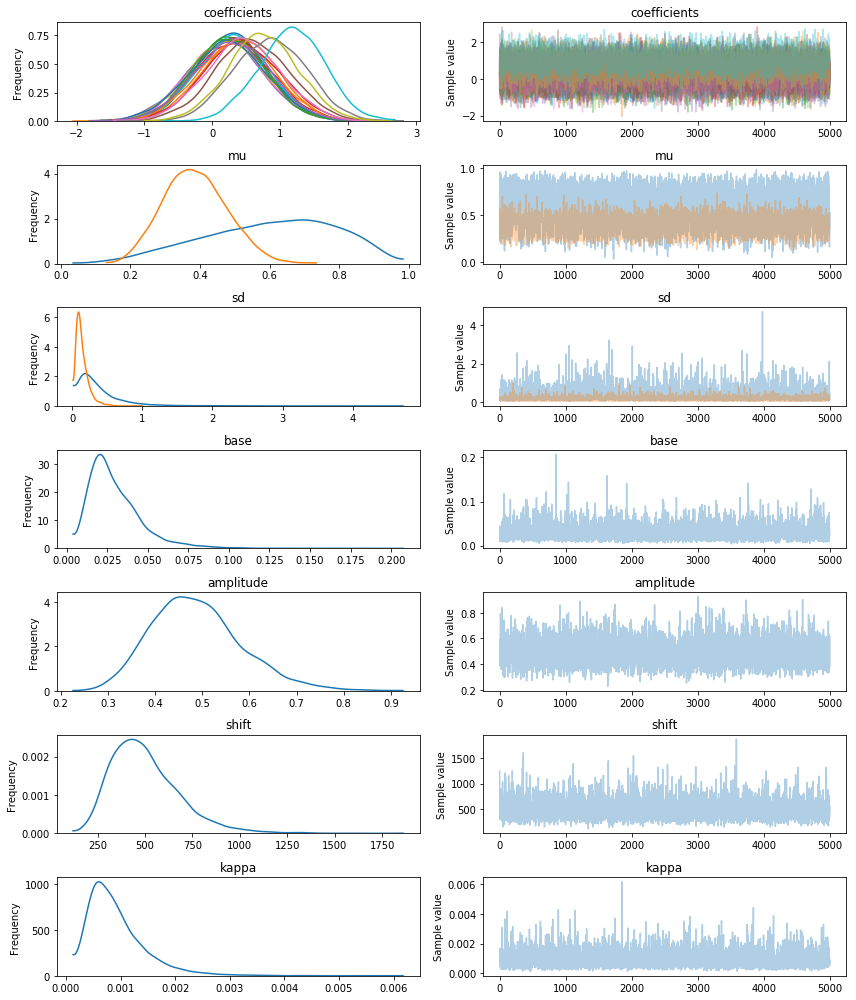

In [15]:
mc.traceplot(trace)